In [1]:
import os

import tensorflow.compat.v1 as tf
from nn_regressors import CNN, RNN, benchmark_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import numpy as np


/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
def clear_saved_regressors():
    to_delete = [
        "cnn_cpu.joblib",
        "cnn_mem.joblib",
        "rnn_cpu.joblib",
        "rnn_mem.joblib",
    ]
    for file in to_delete:
        if os.path.exists(file):
            os.remove(file)

In [3]:
clear_saved_regressors()

In [4]:
cnn_cpu_reg = CNN.CPURegressor()
cnn_mem_reg = CNN.MemoryRegressor()

In [26]:
# Instantiate example models.
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=True, weights="imagenet",
)
resnet = tf.keras.applications.resnet50.ResNet50(include_top=True, weights="imagenet",)
densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights="imagenet",
)
xception = tf.keras.applications.xception.Xception(
    include_top=True, weights="imagenet",
)
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet",)

inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True, weights="imagenet",
)
inception_resnet = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=True, weights="imagenet",
)
nasnet = tf.keras.applications.nasnet.NASNetLarge(include_top=True, weights="imagenet",)

In [34]:
models = [mobilenet, resnet, densenet, xception]
for model in models:
    cnn_cpu_reg.add_model_data(model)
    cnn_mem_reg.add_model_data(model)
    
new_models = [vgg16, inception, inception_resnet, nasnet]

In [27]:
# Compare different regressor types

# Defines custom loss function for LGBM that penalizes underestimates.
# See https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d
def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual > 0, -2 * 10.0 * residual, -2 * residual)
    hess = np.where(residual > 0, 2 * 10.0, 2.0)
    return grad, hess


gbm = lgb.LGBMRegressor()
gbm.set_params(
    **{"objective": custom_asymmetric_train, "num_leaves": 70, "max_bin": 400}, metrics=["mse", "mae"]
)


def get_regressors():
    return [
        Ridge(),
        RandomForestRegressor(n_estimators=750, random_state=42, criterion="mae"),
        Lasso(),
        ElasticNet(),
        SVR(),
        NuSVR(),
        gbm,
    ]

In [28]:
import matplotlib.pyplot as plt
def bar_plot(data_df, title, xlabel, ylabel, ax=None):
    if not ax:
        plt.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xticks(rotation=90)
        plt.show()
    else:
        ax.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

# MASE evaluations

In [35]:
# Fit regressors to new model data.
cnn_cpu_reg.fit(model=SVR())  # Fit an SvR model
cnn_mem_reg.fit()  # default to Random Forest

(     units  filters  kernel_size  activation_linear  activation_softmax  \
 69    -1.0     -1.0         -1.0                0.0                 0.0   
 104   -1.0     -1.0         -1.0                0.0                 0.0   
 120   -1.0     -1.0         -1.0                0.0                 0.0   
 129   -1.0     -1.0          9.0                1.0                 0.0   
 57    -1.0     -1.0         -1.0                0.0                 0.0   
 66    -1.0     -1.0         -1.0                0.0                -1.0   
 146   -1.0     32.0          9.0                1.0                -1.0   
 155   -1.0    512.0          1.0                1.0                 0.0   
 58    -1.0     -1.0         -1.0                0.0                 0.0   
 156   -1.0     -1.0         -1.0                0.0                -1.0   
 39    -1.0     -1.0         -1.0                0.0                -1.0   
 159   -1.0     -1.0         -1.0                0.0                 0.0   
 112   -1.0 

## Predicting CPU for models the regressor was trained on

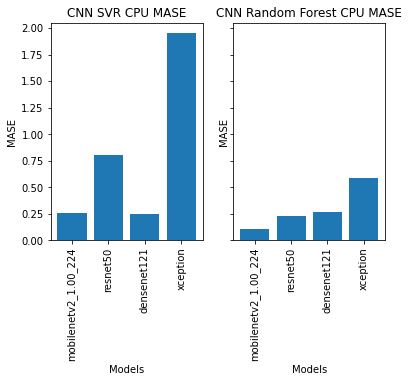

In [36]:
# Predicting CPU for models the regressor was trained on
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

cnn_cpu_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(cnn_cpu_reg.evaluate_mase_multiple(models), "CNN SVR CPU MASE", "Models", "MASE", ax=ax1)

cnn_cpu_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(cnn_cpu_reg.evaluate_mase_multiple(models), "CNN Random Forest CPU MASE", "Models", "MASE", ax=ax2)

plt.show()

## Predicting CPU for models the regressor was NOT trained on

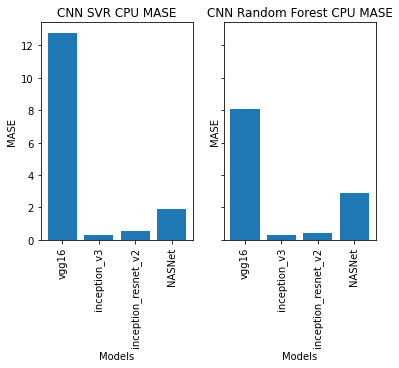

In [37]:
# Predicting CPU for models the regressor was NOT trained on

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

cnn_cpu_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(cnn_cpu_reg.evaluate_mase_multiple(new_models), "CNN SVR CPU MASE", "Models", "MASE", ax=ax1)

cnn_cpu_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(cnn_cpu_reg.evaluate_mase_multiple(new_models), "CNN Random Forest CPU MASE", "Models", "MASE", ax=ax2)

plt.show()

## Predicting memory for models the regressor was trained on

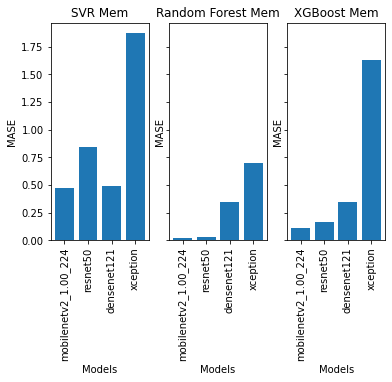

In [38]:
# Predicting memory for models the regressor was trained on
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)


cnn_mem_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(cnn_mem_reg.evaluate_mase_multiple(models), "SVR Mem", "Models", "MASE", ax=ax1)

cnn_mem_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(cnn_mem_reg.evaluate_mase_multiple(models), "Random Forest Mem", "Models", "MASE", ax=ax2)

cnn_mem_reg.fit(model=gbm)
bar_plot(cnn_mem_reg.evaluate_mase_multiple(models), "XGBoost Mem", "Models", "MASE", ax=ax3)

plt.show()

## Predicting memory for models the regressor was NOT trained on

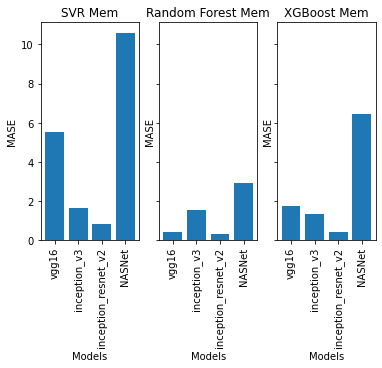

In [39]:
# Predicting memory for models the regressor was trained on

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

cnn_mem_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(cnn_mem_reg.evaluate_mase_multiple(new_models), "SVR Mem", "Models", "MASE", ax=ax1)

cnn_mem_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(cnn_mem_reg.evaluate_mase_multiple(new_models), "Random Forest Mem", "Models", "MASE", ax=ax2)

cnn_mem_reg.fit(model=gbm)
bar_plot(cnn_mem_reg.evaluate_mase_multiple(new_models), "XGBoost Mem", "Models", "MASE", ax=ax3)

plt.show()

# Comparisons of different regression models

In [8]:
mobilenet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), mobilenet)
resnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), resnet)
densenet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), densenet)
xception_cpu_eval = cnn_cpu_reg.compare(get_regressors(), xception)

mobilenet_mem_eval = cnn_mem_reg.compare(get_regressors(), mobilenet)
resnet_mem_eval = cnn_mem_reg.compare(get_regressors(), resnet)
densenet_mem_eval = cnn_mem_reg.compare(get_regressors(), densenet)
xception_mem_eval = cnn_mem_reg.compare(get_regressors(), xception)

In [13]:
inception_resnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), inception_resnet)
nasnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), nasnet)
vgg16_cpu_eval = cnn_cpu_reg.compare(get_regressors(), vgg16)
inception_cpu_eval = cnn_cpu_reg.compare(get_regressors(), inception)

inception_resnet_mem_eval = cnn_mem_reg.compare(get_regressors(), inception_resnet)
nasnet_mem_eval = cnn_mem_reg.compare(get_regressors(), nasnet)
vgg16_mem_eval = cnn_mem_reg.compare(get_regressors(), vgg16)
inception_mem_eval = cnn_mem_reg.compare(get_regressors(), inception)

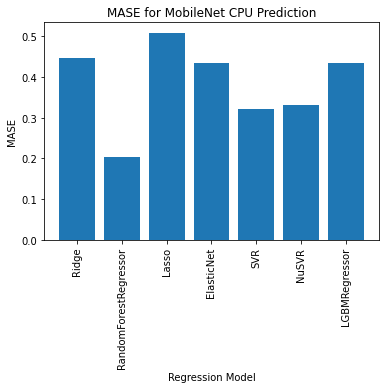

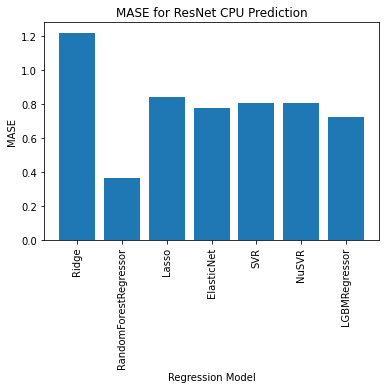

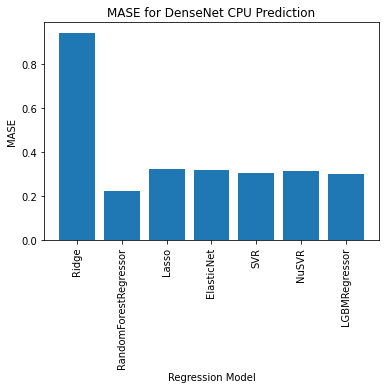

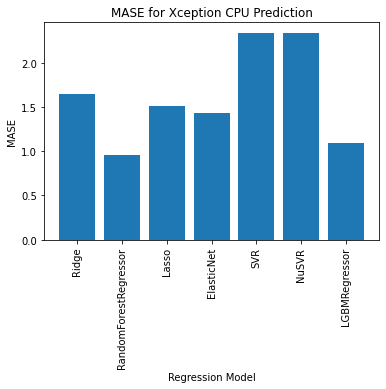

In [14]:
# CPU Predictions for models already trained on
bar_plot(mobilenet_cpu_eval, 'MASE for MobileNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(resnet_cpu_eval, 'MASE for ResNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(densenet_cpu_eval, 'MASE for DenseNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(xception_cpu_eval, 'MASE for Xception CPU Prediction', 'Regression Model', 'MASE')

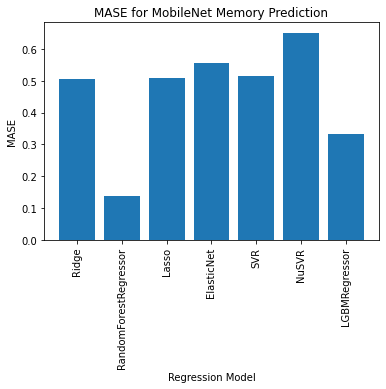

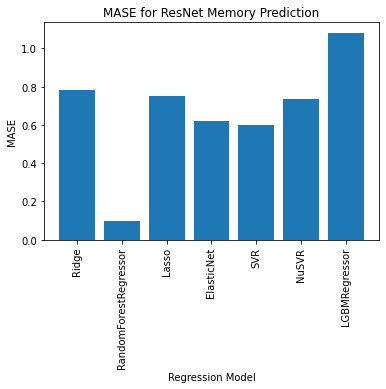

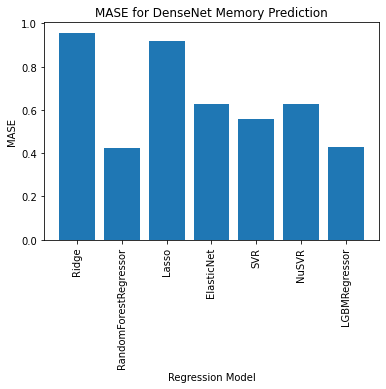

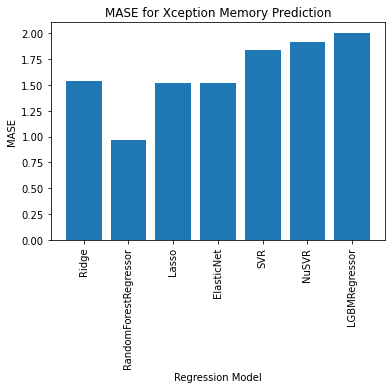

In [15]:
# Memory Predictions for models already trained on
bar_plot(mobilenet_mem_eval, 'MASE for MobileNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(resnet_mem_eval, 'MASE for ResNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(densenet_mem_eval, 'MASE for DenseNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(xception_mem_eval, 'MASE for Xception Memory Prediction', 'Regression Model', 'MASE')

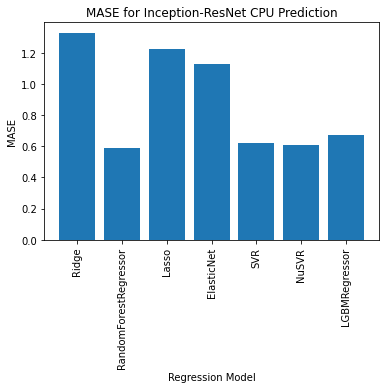

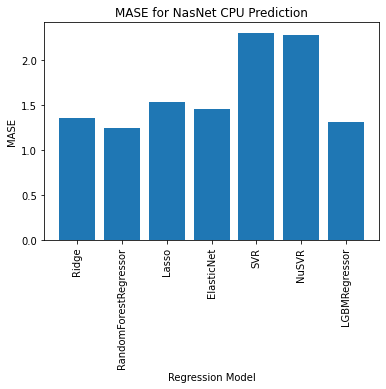

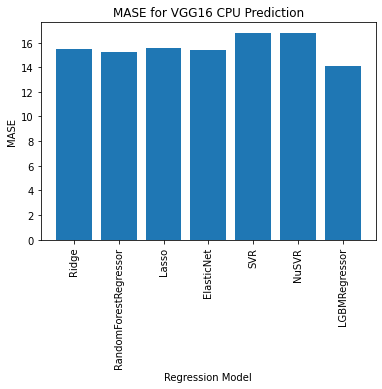

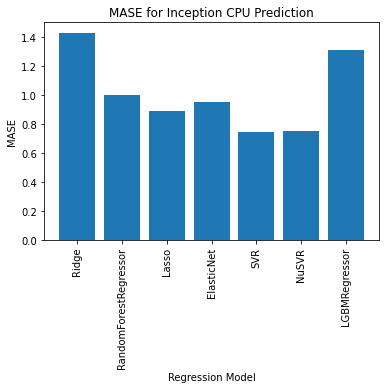

In [16]:
# CPU Predictions for models NOT trained on
bar_plot(inception_resnet_cpu_eval, 'MASE for Inception-ResNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(nasnet_cpu_eval, 'MASE for NasNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(vgg16_cpu_eval, 'MASE for VGG16 CPU Prediction', 'Regression Model', 'MASE')
bar_plot(inception_cpu_eval, 'MASE for Inception CPU Prediction', 'Regression Model', 'MASE')

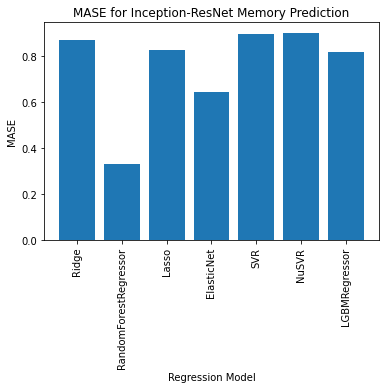

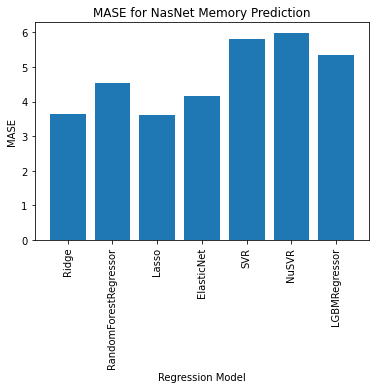

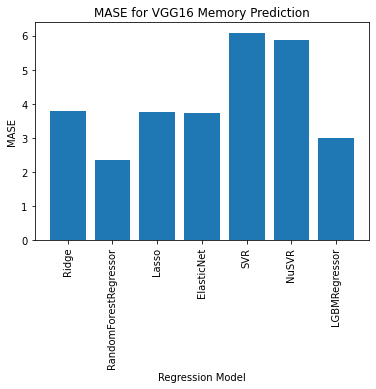

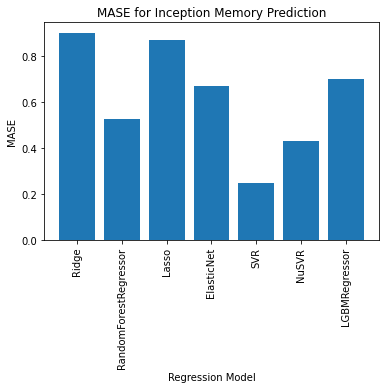

In [17]:
# Memory Predictions for models NOT trained on
bar_plot(inception_resnet_mem_eval, 'MASE for Inception-ResNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(nasnet_mem_eval, 'MASE for NasNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(vgg16_mem_eval, 'MASE for VGG16 Memory Prediction', 'Regression Model', 'MASE')
bar_plot(inception_mem_eval, 'MASE for Inception Memory Prediction', 'Regression Model', 'MASE')